In [5]:
# I'm adding a version of this code that was used to draft a version of the manuscript. It includes some 
# un-used analyses (like a pretty effect size matrix / heatmap) and probably a lot of attempts to do things.
# If it hasn't been cleaned up before publication, it should be .... 
# Anything good in here was probably written by chatGPT, and anything bad was probably written by me
# npetersen@ucla.edu 08/06/2024

# there is a conflict between ptitprince and numpy

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
#import ptitprince as pt
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import colorsys

# load in csv version of datasheet and give the full path so you can run this from anywhere
file_path = '/u/home/n/npeterse/TMS_data_copy.csv'
data = pd.read_csv(file_path)

# and stop cutting off data!
pd.set_option('display.max_rows', None)  


# lets make a little dictionary of important variables
# sometimes you want the main dvs, sometimes you want all dvs. maybe that should go inside the relevant cells
# even if redundant

dvs = ['SJW_SUM_C', 'SJW_SUM_PSY', 'SJW_SUM_PHY', 'SJW_SUM_SS', 'SJW_SUM_OVERALL', 'PANAS_POS_TOT', 'PANAS_NEG_TOT', 'UTS_TOT']
experimental_targets = ['PPC', 'SFG', 'DLPFC']
control_target = 'v5'
targets = ['PPC', 'SFG', 'v5', 'DLPFC']
ordered_targets = ['DLPFC', 'SFG', 'PPC', 'v5']
subset_data = data.dropna(subset=dvs + ['PrePost', 'PTID'])
required_columns = ['PANAS_POS_TOT', 'SJW_SUM_OVERALL', 'STITARGET', 'PrePost', 'PTID', 'SJW_SUM_C', 'SJW_SUM_PSY', 'SJW_SUM_PHY', 'SJW_SUM_SS', 'SJW_SUM_A', 'SJW_SUM_OVERALL']
data_clean = data.dropna(subset=required_columns)

target_colors = {
    'SFG': '#1ABC9C', 
    'DLPFC': '#1A8BBC',
    'PPC': '#9563d0', 
    'v5': '#7f7f7f'  
}

# labels for figures:
label_translation = {
    'SJW_SUM_C_PPC': 'Craving (SJ)',
    'SJW_SUM_C_SFG': 'Craving (SJ)',
    'SJW_SUM_C_v5': 'Craving (SJ)',
    'SJW_SUM_C_DLPFC': 'Craving (SJ)',
    'SJW_SUM_PSY_PPC': 'Psych Withdrawal',
    'SJW_SUM_PSY_SFG': 'Psych Withdrawal',
    'SJW_SUM_PSY_v5': 'Psych Withdrawal',
    'SJW_SUM_PSY_DLPFC': 'Psych Withdrawal',
    'SJW_SUM_PHY_PPC': 'Physio Withdrawal',
    'SJW_SUM_PHY_SFG': 'Physio Withdrawal',
    'SJW_SUM_PHY_v5': 'Physio Withdrawal',
    'SJW_SUM_PHY_DLPFC': 'Physio Withdrawal',
    'SJW_SUM_SS_PPC': 'Stim/Sedate',
    'SJW_SUM_SS_SFG': 'Stim/Sedate',
    'SJW_SUM_SS_v5': 'Stim/Sedate',
    'SJW_SUM_SS_DLPFC': 'Stim/Sedate',
    'SJW_SUM_A_PPC': 'Appetite',
    'SJW_SUM_A_SFG': 'Appetite',
    'SJW_SUM_A_v5': 'Appetite',
    'SJW_SUM_A_DLPFC': 'Appetite',
    'SJW_SUM_OVERALL_PPC': 'Withdrawal sum',
    'SJW_SUM_OVERALL_SFG': 'Withdrawal sum',
    'SJW_SUM_OVERALL_v5': 'Withdrawal sum',
    'SJW_SUM_OVERALL_DLPFC': 'Withdrawal sum',
    'PANAS_POS_TOT_PPC': '+Affect',
    'PANAS_POS_TOT_SFG': '+Affect',
    'PANAS_POS_TOT_v5': '+Affect',
    'PANAS_POS_TOT_DLPFC': '+Affect',
    'PANAS_NEG_TOT_PPC': '-Affect',
    'PANAS_NEG_TOT_SFG': '-Affect',
    'PANAS_NEG_TOT_v5': '-Affect',
    'PANAS_NEG_TOT_DLPFC': '-Affect',
    'UTS_TOT_PPC': 'Craving (UTS)',
    'UTS_TOT_SFG': 'Craving (UTS)',
    'UTS_TOT_v5': 'Craving (UTS)',
    'UTS_TOT_DLPFC': 'Craving (UTS)',
}
# uncomment the line below to display the first few rows of the dataframe
#data.head()

In [7]:
# Initialize dictionaries to store results for males and females
male_results = {}
female_results = {}

# Filter data for males and females
male_data = subset_data[subset_data['Sex'] == 'Male']
female_data = subset_data[subset_data['Sex'] == 'Female']

# define functions
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

def calculate_effect_sizes(data, gender_results):
    for dependent_variable in dvs:
        for target in targets:
            # Filter the data for the specific target and dependent variable
            subset_data = data[data['STITARGET'] == target].dropna(subset=[dependent_variable, 'PrePost', 'PTID'])
            
            if not subset_data.empty:
                # Separate pre and post data
                pre_data = subset_data[subset_data['PrePost'] == 'Pre'][dependent_variable]
                post_data = subset_data[subset_data['PrePost'] == 'Post'][dependent_variable]
                
                # Calculate effect size (Cohen's d) for the target and dependent variable
                if len(pre_data) > 1 and len(post_data) > 1:  # Ensure enough data points for comparison
                    effect_size = cohen_d(pre_data, post_data)
                    gender_results[f'{dependent_variable}_{target}'] = effect_size

# Calculate effect sizes for males and females
calculate_effect_sizes(male_data, male_results)
calculate_effect_sizes(female_data, female_results)

# Convert results to DataFrames
male_results_sorted = pd.DataFrame.from_dict(male_results, orient='index', columns=['Effect Size']).sort_values(by='Effect Size', ascending=False)
female_results_sorted = pd.DataFrame.from_dict(female_results, orient='index', columns=['Effect Size']).sort_values(by='Effect Size', ascending=False)

male_min_effect_size = male_results_sorted['Effect Size'].min()
male_max_effect_size = male_results_sorted['Effect Size'].max()
print(f"Range of effect sizes for males: {male_min_effect_size} to {male_max_effect_size}")

# Calculate and print the range of effect sizes for females
female_min_effect_size = female_results_sorted['Effect Size'].min()
female_max_effect_size = female_results_sorted['Effect Size'].max()
print(f"Range of effect sizes for females: {female_min_effect_size} to {female_max_effect_size}")

# Dictionary for sex-specific results
sex_specific_results = {}

# Calculate and store effect sizes by sex and target
for dependent_variable in dvs:
    for target in targets:
        for sex in ['Male', 'Female']:
            sex_subset_data = subset_data[(subset_data['STITARGET'] == target) & (subset_data['Sex'] == sex)]
            sex_subset_data = sex_subset_data.dropna(subset=[dependent_variable, 'PrePost', 'PTID'])
            if not sex_subset_data.empty:
                pre_data = sex_subset_data[sex_subset_data['PrePost'] == 'Pre'][dependent_variable]
                post_data = sex_subset_data[sex_subset_data['PrePost'] == 'Post'][dependent_variable]
                d = cohen_d(pre_data, post_data)
                sex_specific_results[f'{dependent_variable}_{target}_{sex}'] = {
                    'effect_size (Cohen\'s d)': d
                }
            else:
                sex_specific_results[f'{dependent_variable}_{target}_{sex}'] = {
                    'effect_size (Cohen\'s d)': None
                }


# Optional: flip the sign of PANAS_POS_TOT if needed
for key in sex_specific_results.keys():
    if 'PANAS_POS_TOT' in key and sex_specific_results[key]['effect_size (Cohen\'s d)'] is not None:
        sex_specific_results[key]['effect_size (Cohen\'s d)'] *= -1

# Convert sex-specific results to a DataFrame
sex_specific_results_df = pd.DataFrame.from_dict(sex_specific_results, orient='index')
print(sex_specific_results_df)


Range of effect sizes for males: -0.237203575730536 to 0.5866632943601434
Range of effect sizes for females: -0.4077954358702775 to 0.3040356531404037
                              effect_size (Cohen's d)
SJW_SUM_C_PPC_Male                           0.158450
SJW_SUM_C_PPC_Female                         0.098538
SJW_SUM_C_SFG_Male                           0.422990
SJW_SUM_C_SFG_Female                         0.300335
SJW_SUM_C_v5_Male                            0.177493
SJW_SUM_C_v5_Female                          0.077637
SJW_SUM_C_DLPFC_Male                         0.453120
SJW_SUM_C_DLPFC_Female                       0.304036
SJW_SUM_PSY_PPC_Male                         0.333534
SJW_SUM_PSY_PPC_Female                       0.032877
SJW_SUM_PSY_SFG_Male                         0.586663
SJW_SUM_PSY_SFG_Female                      -0.019147
SJW_SUM_PSY_v5_Male                          0.166627
SJW_SUM_PSY_v5_Female                       -0.407795
SJW_SUM_PSY_DLPFC_Male                 

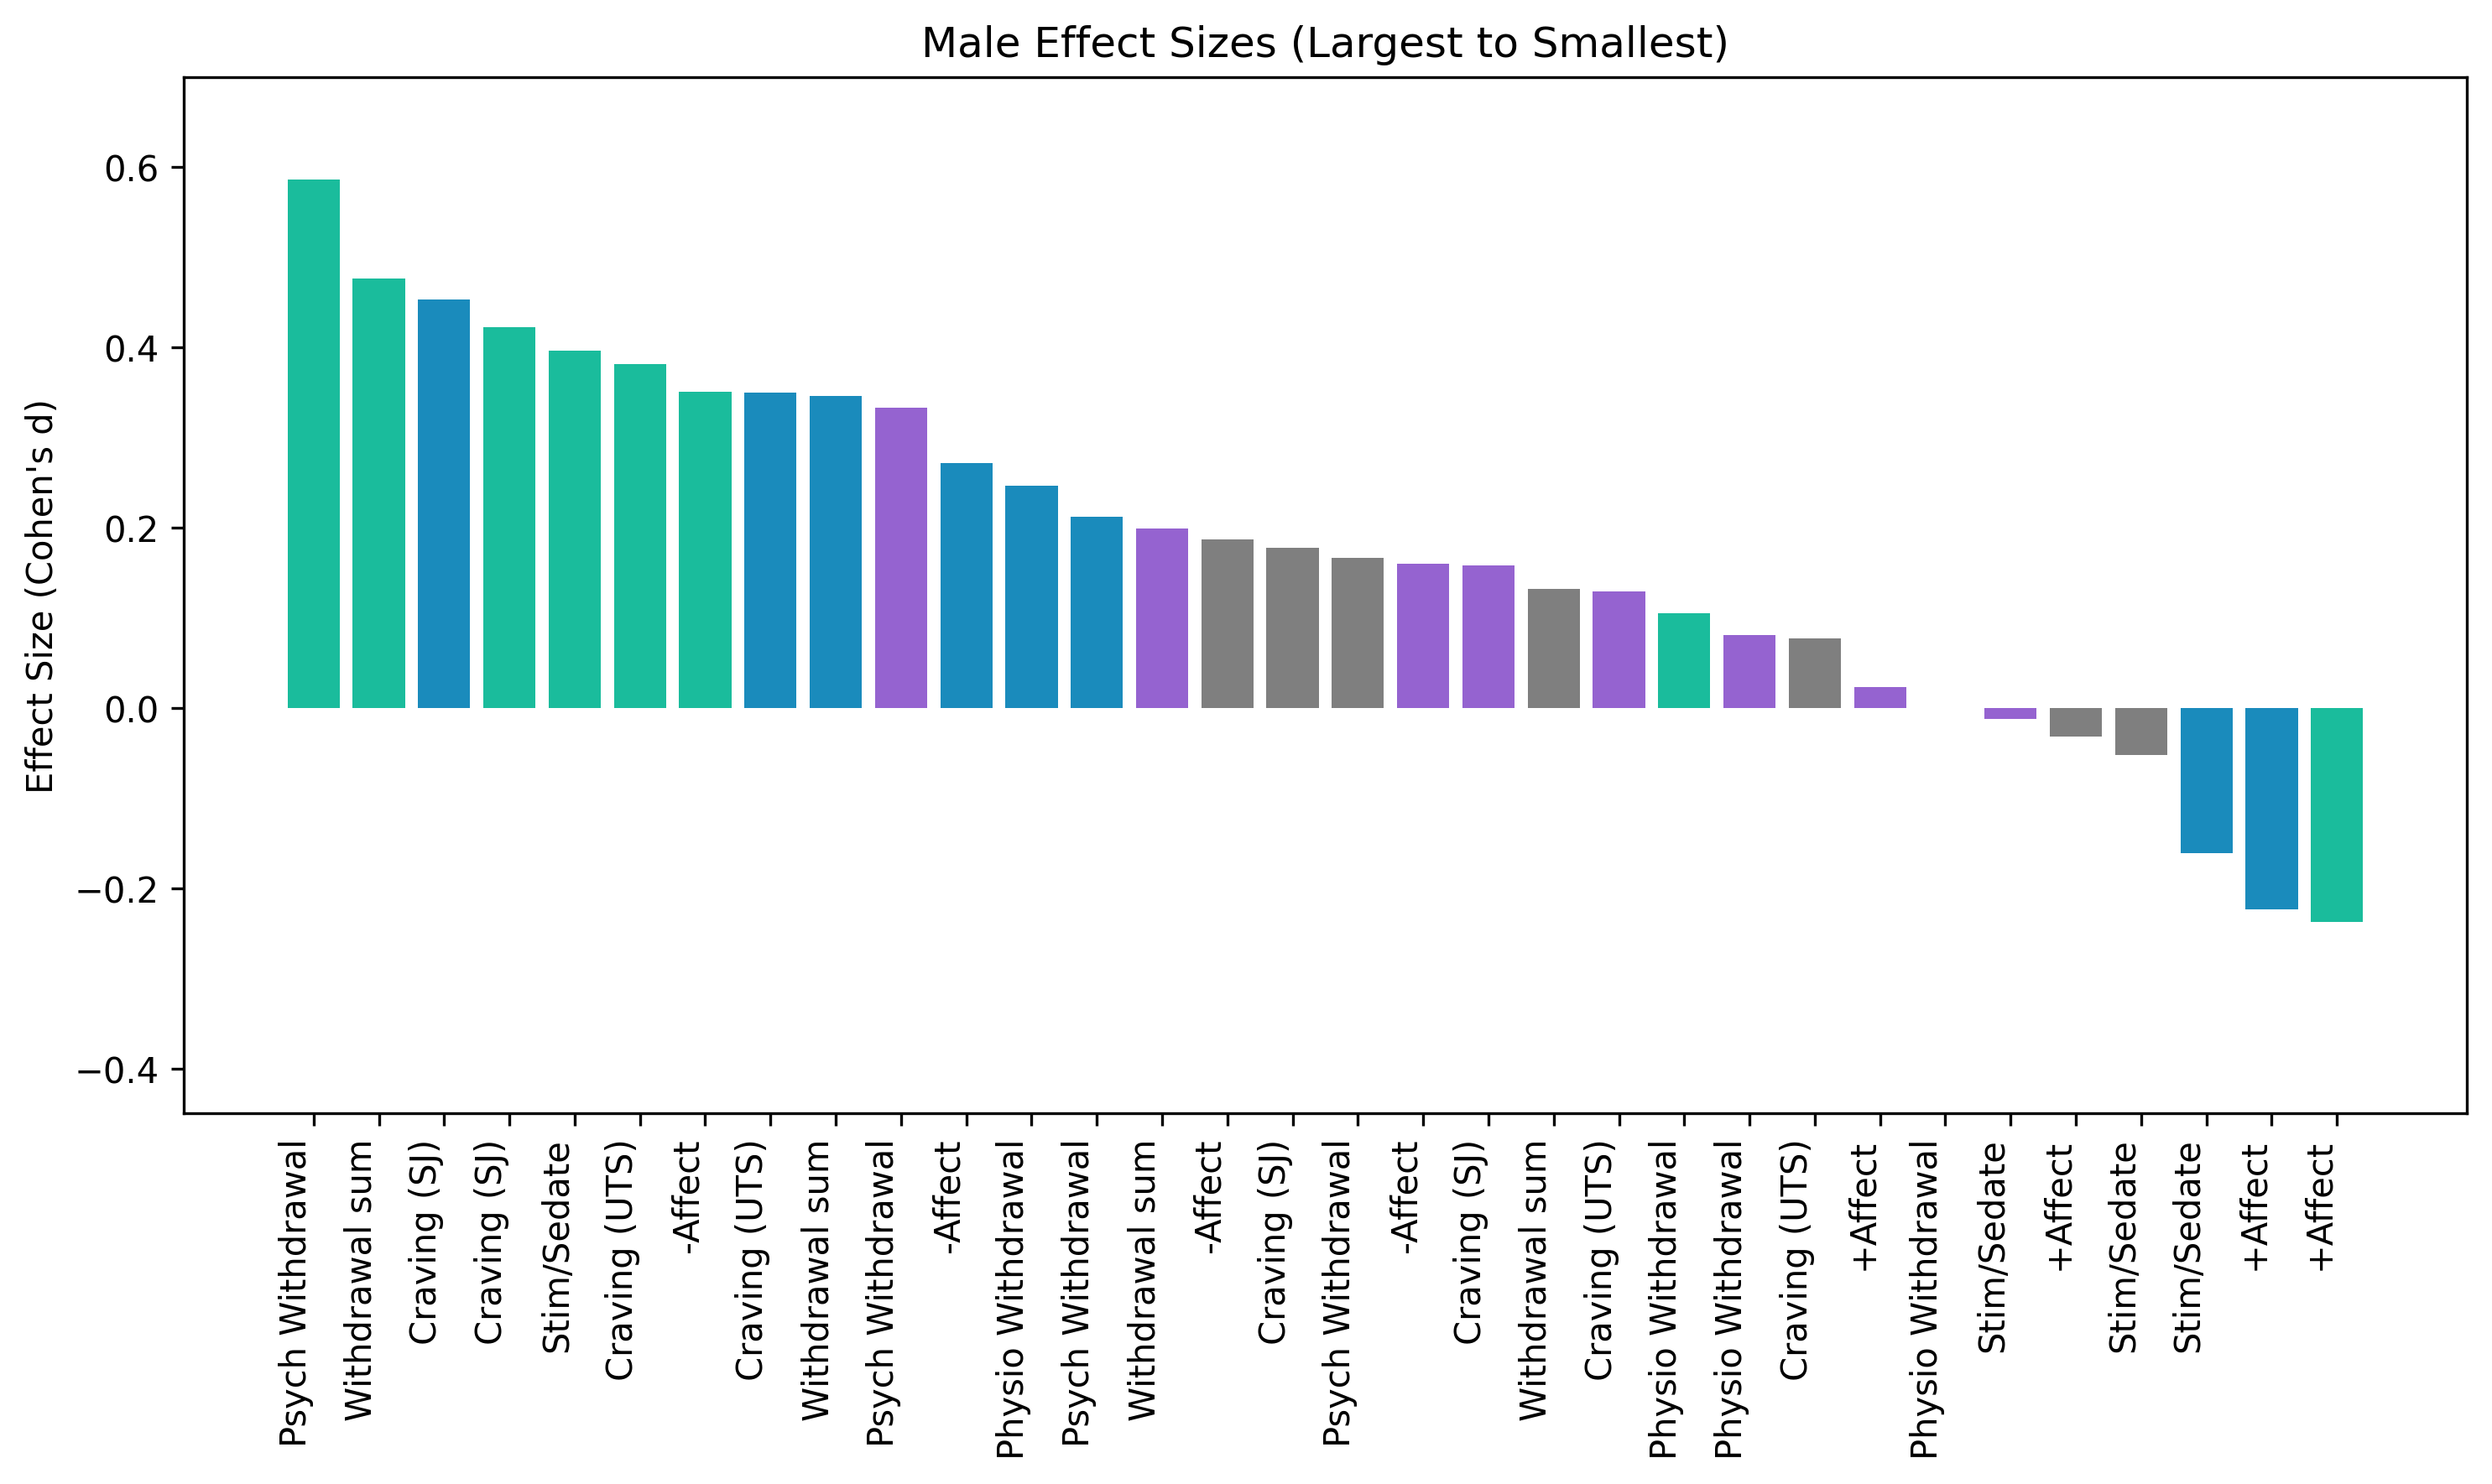

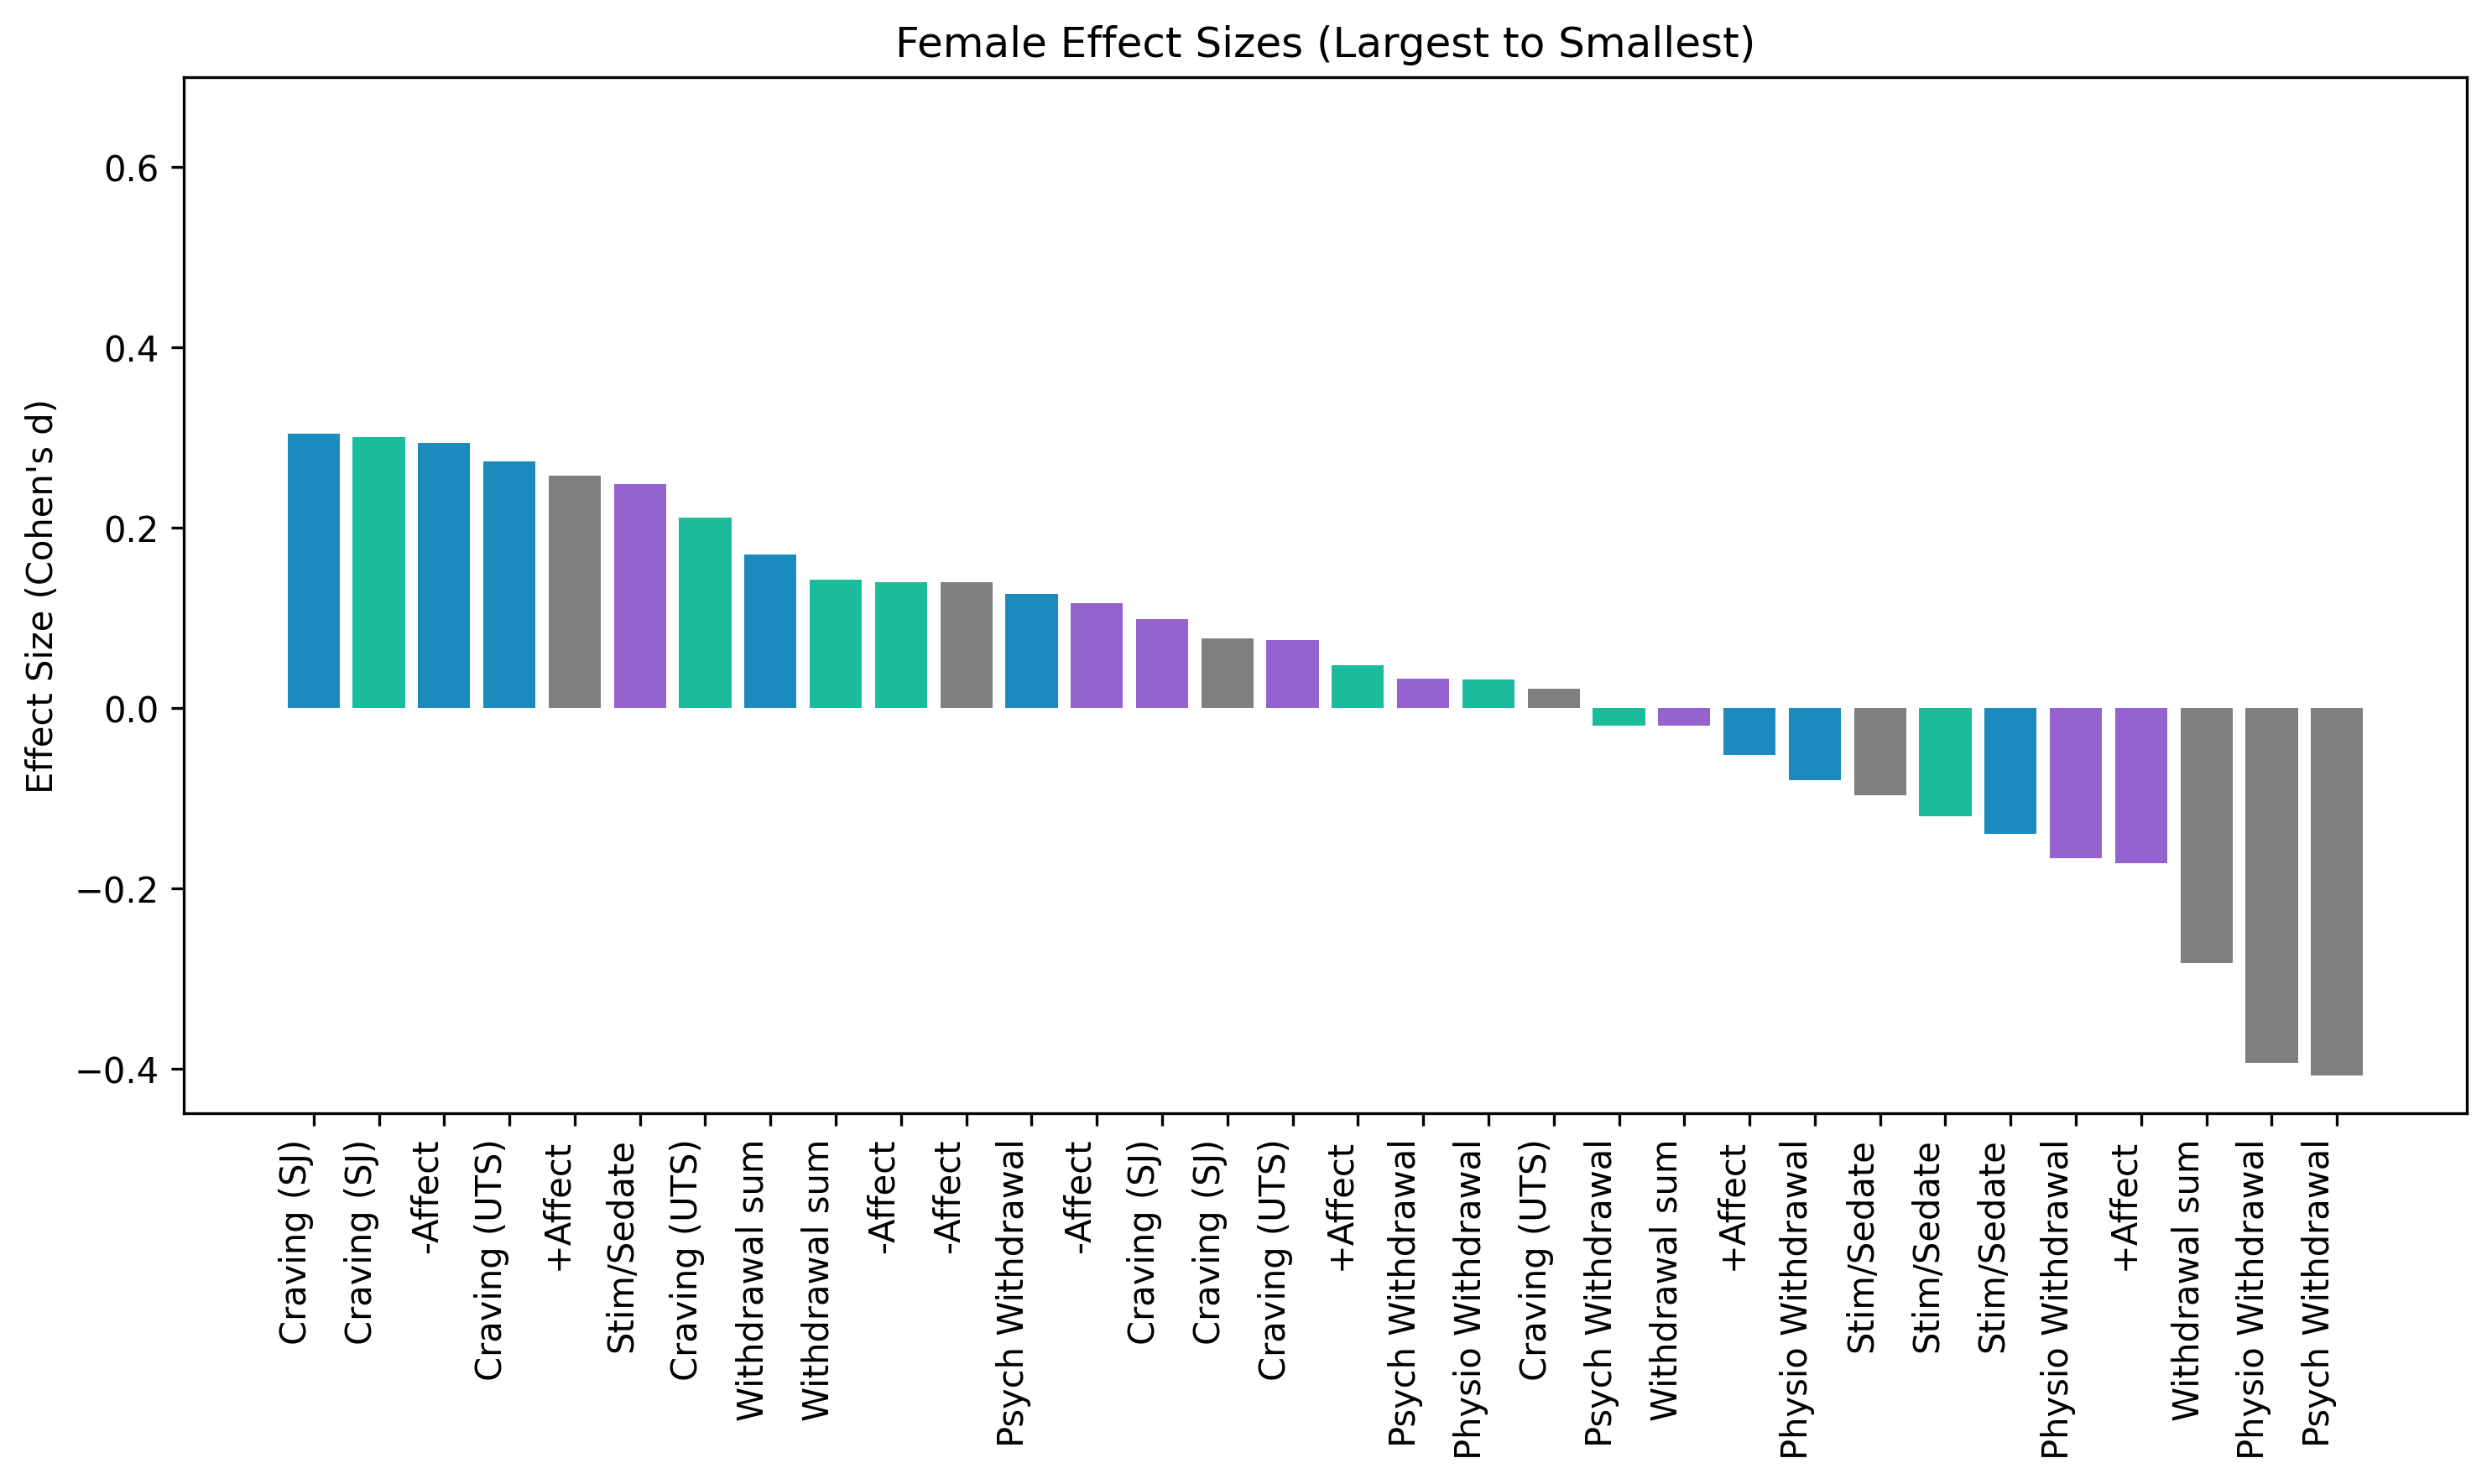

In [4]:
# this plot is a nightmare to make. adding the labels messes everything up. don't touch it unless you have to.

# Function to map index to target color
def get_target_color(effect_index, target_colors):
    split_index = effect_index.split('_')
    target = split_index[-1]
    return target_colors.get(target, '#7f7f7f')  # Default to grey if the target is not found

# Function to translate labels using the provided label_translation dictionary
def translate_label(effect_index, label_translation):
    return label_translation.get(effect_index, effect_index)  # Default to original index if no match

# Concatenate male and female results into separate DataFrames
male_effects = pd.DataFrame.from_dict(male_results, orient='index', columns=['Effect Size']).sort_values(by='Effect Size', ascending=False)
female_effects = pd.DataFrame.from_dict(female_results, orient='index', columns=['Effect Size']).sort_values(by='Effect Size', ascending=False)

# Get the corresponding colors for each male and female effect size
male_colors = [get_target_color(idx, target_colors) for idx in male_effects.index]
female_colors = [get_target_color(idx, target_colors) for idx in female_effects.index]

# Translate the x-axis labels
male_labels = [translate_label(idx, label_translation) for idx in male_effects.index]
female_labels = [translate_label(idx, label_translation) for idx in female_effects.index]

# Create numerical positions for each bar
male_positions = np.arange(len(male_effects))
female_positions = np.arange(len(female_effects))

# Plot all male effect sizes with target-specific colors and translated labels
plt.figure(figsize=(10, 6), dpi=300)
plt.bar(male_positions, male_effects['Effect Size'], color=male_colors)
plt.ylim(-0.45, 0.7)
plt.title('Male Effect Sizes (Largest to Smallest)')
plt.ylabel('Effect Size (Cohen\'s d)')
plt.xticks(male_positions, male_labels, rotation=90, ha='right')
plt.tight_layout()

# Display the first plot (male effects)
plt.show()

# Plot all female effect sizes with target-specific colors and translated labels
plt.figure(figsize=(10, 6), dpi=300)
plt.bar(female_positions, female_effects['Effect Size'], color=female_colors)
plt.ylim(-0.45, 0.7)
plt.title('Female Effect Sizes (Largest to Smallest)')
plt.ylabel('Effect Size (Cohen\'s d)')
plt.xticks(female_positions, female_labels, rotation=90, ha='right')
plt.tight_layout()

# Display the second plot (female effects)
plt.show()
